In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default') 
import itertools
import pickle
import os
import shap

from scikeras.wrappers import KerasClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score


path_train_data = "data/train_data_fold_split.csv"
path_test_data = "data/test_data.csv"
path_train_data_strat = "data/train_data_fold_split_strat.csv"
path_test_data_strat = "data/test_data_strat.csv"

nested_cv_results_file = 'results/nested_cv_results.pkl'
grid_best_result_file = 'results/grid_best_result.pkl'
# nested_cv_lasso_results_file = 'results/nested_cv_lasso_results.pkl'
lasso_grid_best_result_file = 'results/lasso_grid_best_result.pkl'
strat_grid_best_result_file = 'results/strat_grid_best_result.pkl'
strat_lasso_grid_best_result_file = 'results/strat_lasso_grid_best_result.pkl'
lasso_grid_shap_file = 'results/lasso_grid_shap.pkl'
strat_lasso_grid_shap_file = 'results/strat_lasso_grid_shap.pkl'

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

### 4. Neural Network
#### 4.1. Problem and Overview

As mentioned in the section 3. Regression model, the gallstone status prediction is a classification problem with a few key challenges: a small sample size, potential gender imbalance, and excessive and correlated features. Our goal is to build and evaluate models that are robust, generalizable, and interpretable. In this notebook, we will use a Neural Network (NN) implemented with Keras and scikeras.wrappers.KerasClassifier to address these challenges.


#### 4.2. Data Splitting and Preprocessing

The data splitting and preprocessing strategy are identical to the ones described in the 2. Splitting Strategy section. A 30% held-out test set is used for the final, unbiased evaluation, with the remaining 70% used for all model development, including a 5-fold cross-validation approach with stratification.

In [34]:
# same as for regression model

train_data = pd.read_csv(path_train_data)
test_data  = pd.read_csv(path_test_data)

folds = train_data[[c for c in train_data.columns if c.startswith("Fold")]]
fold_names = folds.columns.to_list()
strat_columns = ["strat"]
exclude_features = ["hyperlipidemia", "hypothyroidism", "cad"]

X_train = train_data.drop(fold_names + ["gallstone"] + strat_columns + exclude_features, axis = 1)
y_train = train_data["gallstone"]
X_test = test_data.drop(["gallstone"] + strat_columns + exclude_features, axis = 1)
y_test = test_data["gallstone"]

splits = []

for fold in fold_names:
    train_idx =  folds.index[folds[fold] == "train"].to_numpy()
    val_idx = folds.index[folds[fold] == "val"].to_numpy()
    splits.append((train_idx.tolist(), val_idx.tolist()))

#### 4.3. Model Evaluation Concept

For evaluation, we use the same concept and the same utilities that were described in the Regression model section. Namely, we check scores on each fold, the entire training set, and the test set. For the fold score, the model is trained on the fold's training data and evaluated on its held-out validation set. After the cross-validation loop, the final model is retrained on the entire training set, and its performance is evaluated on the final, unseen test set. The main difference with the evaluation routine for the regression model is that for the NN we use the EarlyStopping callback to monitor the validation loss and stop the training at the right moment.

The scores are saved in a JSON-like format for easy analysis. We use the following metrics for pipeline evaluation: accuracy, ROC AUC, recall, and precision. ROC AUC was chosen for model optimization as it is a robust and standard metric in biomedical modeling.

In [35]:
# import importlib
# import scripts.pipeline_utils
# importlib.reload(scripts.pipeline_utils) 

from scripts.pipeline_utils import get_pipeline_results, show_pipeline_summary

#### 4.4. NN Architecture Selection

A critical step in model development is selecting an architecture that is complex enough to capture underlying patterns but simple enough to avoid overfitting. To find the optimal architecture for this dataset, we tested four distinct network structures and evaluated their performance based on ROC AUC scores.

The following architectures were considered:

- One hidden layer with 32 neurons (baseline NN)

- Two hidden layers with 32 and 16 neurons (deep NN)

- One hidden layer with 64 neurons (wide NN)

- Two hidden layers with 64 and 32 neurons (deep and wide NN)


In [36]:
nn_pipelines_results = []

def create_nn_1(input_dim):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim, )),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

nn_pipeline_1 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(model = create_nn_1(input_dim=X_train.shape[1]),
                           epochs=20, batch_size=32, verbose=0))
])

nn_pipelines_results.append(get_pipeline_results(
    nn_pipeline_1, name="baseline nn", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names, pipeline_type="nn"
    ))
# show_pipeline_summary(nn_pipelines_results)

In [37]:
def create_nn_2(input_dim):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim, )),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

nn_pipeline_2 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(model = create_nn_2(input_dim=X_train.shape[1]),
                           epochs=20, batch_size=32, verbose=0))
])

nn_pipelines_results.append(get_pipeline_results(
    nn_pipeline_2, name="deep nn", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names, pipeline_type="nn"
    ))
# show_pipeline_summary(nn_pipelines_results)

In [38]:
def create_nn_3(input_dim):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim, )),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

nn_pipeline_3 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(model = create_nn_3(input_dim=X_train.shape[1]),
                           epochs=20, batch_size=32, verbose=0))
])

nn_pipelines_results.append(get_pipeline_results(
    nn_pipeline_3, name="wide nn", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names, pipeline_type="nn"
    ))
# show_pipeline_summary(nn_pipelines_results)

In [39]:
def create_nn_4(input_dim):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim, )),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

nn_pipeline_4 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(model = create_nn_4(input_dim=X_train.shape[1]),
                           epochs=20, batch_size=32, verbose=0))
])

nn_pipelines_results.append(get_pipeline_results(
    nn_pipeline_4, name="deep and wide nn", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names, pipeline_type="nn"
    ))
show_pipeline_summary(nn_pipelines_results)

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
baseline nn,0.911,0.105,1.000,0.747,0.949,0.098,1.000,0.808,0.888,0.159,1.000,0.702,0.923,0.093,1.000,0.767
deep nn,0.942,0.086,1.000,0.726,0.966,0.081,1.000,0.819,0.924,0.129,1.000,0.681,0.957,0.067,1.000,0.744
wide nn,0.921,0.109,1.000,0.726,0.960,0.086,1.000,0.794,0.909,0.145,1.000,0.660,0.929,0.106,1.000,0.756
deep and wide nn,0.947,0.099,1.000,0.726,0.969,0.089,1.000,0.805,0.939,0.124,1.000,0.702,0.952,0.099,1.000,0.733



Based on the cross-validation results, the architecture with two hidden layers (32 and 16 neurons) consistently provided the best ROC AUC performance. This choice also aligns well with the project's goal of demonstrating a robust and efficient model without unnecessary complexity. The selected architecture offers a strong balance between a high-performing model and a conservative design that reduces the risk of overfitting, making it a suitable choice for this small, noisy dataset.

#### 4.5. Hyperparameter Tuning with Manual Cross-Validation

Clearly, all of our models overfit and the regularization is required. The process of finding the optimal set of hyperparameters for a neural network is critical to achieving a high-performing and generalizable model.

**The Role of GridSearchCV**

A standard and convenient approach for this task is sklearn.model_selection.GridSearchCV. GridSearchCV automates the process of exhaustively searching through a specified grid of hyperparameters, performing cross-validation, and selecting the best-performing model. This provides a robust, out-of-the-box solution for hyperparameter tuning.

**Why a Manual Loop was Chosen**

While GridSearchCV is powerful, it lacks a straightforward mechanism for providing a specific validation dataset to the model within each cross-validation fold. To properly utilize the EarlyStopping callback, it is essential to monitor a held-out set that is separate from the training data for that specific fold.

For this reason, a manual cross-validation loop was implemented. This provided the necessary control to explicitly pass the X_val_fold and y_val_fold to the pipeline.fit method in each iteration. This approach ensures that EarlyStopping correctly monitors the performance on each fold's validation data, guaranteeing an unbiased selection of the best mode

**Regularization Parameters**

As discussed in the regression model section, we use a combination of L1 and L2 regularization (known as Elastic Net) to constrain model weights. These methods were applied directly to the dense layers of the network to prevent weights from growing too large.

Unique to neural networks, we also employed Dropout, a powerful regularization method. Dropout randomly sets a fraction of neuron outputs to zero during each training step. This prevents neurons from co-adapting and relying too heavily on specific features, forcing the network to learn a more robust and redundant set of features. The dropout_rate parameter controls the percentage of neurons that are "dropped out."

In addition, we tuned the **learning rate** and **batch size** to find a balance between stable training and efficient convergence. The learning rate controls the optimizer's step size, while the batch size dictates the number of samples per gradient update. A smaller batch size requires a lower learning rate to prevent instability.


In [40]:
def run_manual_grid_search(X_data, y_data, splits, hyperparams, nn_model_func, callbacks, ndims):
    """
    Performs a manual grid search with cross-validation if fitting results are not present

    Args:
        X_data: The feature data for the grid search.
        y_data: The target data.
        splits: Cross-validation splits
        hyperparams: Dictionary of hyperparameters to search.
        nn_model_func: The function to create the neural network model.
        callbacks: Keras callbacks for fitting.

    Returns:
        Best result (params, mean score, score std), either calculated or read from file
    """

    param_names = list(hyperparams.keys())
    param_values = list(hyperparams.values())
    all_combos = list(itertools.product(*param_values))
    grid_cv_results = []
    
    print(f"Starting grid search on {len(all_combos)} parameter combinations...")

    for combo in all_combos:
        current_params = dict(zip(param_names, combo))
        
        model_params = {
            'model__dropout_rate': current_params['dropout_rate'],
            'model__l1_strength': current_params['l1_strength'],
            'model__l2_strength': current_params['l2_strength'],
            'model__learning_rate': current_params['learning_rate'],
            'model__ndims': ndims
        }
                        
        fold_scores = []
        
        for (train_index, val_index) in splits:
            X_train_fold, y_train_fold = X_data[train_index], y_data[train_index]
            X_val_fold, y_val_fold = X_data[val_index], y_data[val_index]

            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ('nn', KerasClassifier(
                    model=nn_model_func,
                    epochs=50,
                    batch_size=current_params["batch_size"],
                    verbose=0,
                    **model_params
                ))
            ])
            
            pipeline.fit(X_train_fold, y_train_fold, 
                        nn__callbacks=[callbacks], 
                        nn__validation_data=(X_val_fold, y_val_fold)) # <- that's why we need to do a manual loop and can not use GridCV directly
            
            y_proba = pipeline.predict_proba(X_val_fold)[:, 1]
            score = roc_auc_score(y_val_fold, y_proba)
            fold_scores.append(score)
        
        results_dict = {
            'params': current_params,
            'mean_test_score': np.mean(fold_scores),
            'std_test_score': np.std(fold_scores),
            'split_test_scores': fold_scores
        }
        grid_cv_results.append(results_dict)
        
        avg_score = np.mean(fold_scores)
        print(f"  > Average score for params {current_params}: {avg_score:.4f}")

    best_result = max(grid_cv_results, key=lambda x: x['mean_test_score'])

    
    return best_result

In [41]:
def create_deep_nn(dropout_rate=0.0, l1_strength = 0.0, l2_strength = 0.0, learning_rate = 0.1, ndims = X_train.shape[1]):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(ndims,)),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

hyperparameters = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32],
    'dropout_rate': [0.1, 0.2, 0.5],
    'l1_strength': [0.0, 0.01, 0.001],
    'l2_strength': [0.0, 0.01, 0.001],
}

In [42]:
# check if results file exists
if os.path.exists(grid_best_result_file):
    with open(grid_best_result_file, 'rb') as f:
        grid_best_result= pickle.load(f)
    print("Grid best result successfully loaded!")

else:
    print("Grid best result file not found. Starting fitting process...")
    
    grid_best_result = run_manual_grid_search(
        X_train.values, y_train.values, 
        splits, hyperparameters,
        nn_model_func = create_deep_nn, callbacks = early_stopping,
        ndims=X_train.shape[1]
        )

    with open(grid_best_result_file, 'wb') as f:
        pickle.dump(grid_best_result, f)

    print(f"Results successfully saved to {grid_best_result_file}")

grid_best_params = grid_best_result['params']
print("\n--- Final Results ---")
print(f"Best params: {grid_best_params}")
print(f"Best average score: {grid_best_result["mean_test_score"]:.4f}")

Grid best result successfully loaded!

--- Final Results ---
Best params: {'learning_rate': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'l1_strength': 0.0, 'l2_strength': 0.001}
Best average score: 0.8347


**Nested CV**

Nested cross-validation is a robust method to get an unbiased estimate of a model's performance. It prevents data leakage by using two loops:

1. Outer Loop: For model evaluation. The data is split into a training set and a final, unseen test set.

2. Inner Loop: For hyperparameter tuning. It operates only on the training data from the outer loop.

This process gives a more realistic final performance score. In addition, we can also use nested CV results to select the parameter set with the best outer score for a final model. 

In [43]:
# check if results file exists
if os.path.exists(nested_cv_results_file):
    with open(nested_cv_results_file, 'rb') as f:
        nested_cv_results = pickle.load(f)
    print("Nested CV results successfully loaded!")
    (best_params_per_fold, nested_cv_scores) = nested_cv_results
else:
    print("Nested CV results file not found. Starting fitting process...")
    nested_cv_scores = []
    best_params_per_fold = []
    # Loop through outer folds for cross-validation
    cur_nested_cv_results_file = 'results/cur_nested_cv_results.pkl'
    for (train_index, test_index) in splits[0:5]: # we do 5 splits only due to computational resources
            X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
            X_test_fold, y_test_fold = X_train.iloc[test_index], y_train.iloc[test_index]

            # Inner loop for hyperparameter tuning
            # Same stratification for inner and outer loop
            strat_fold= train_data.iloc[train_idx]["gallstone"]
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            inner_cv = list(skf.split(X_train_fold, strat_fold))
            
            best_inner_result = run_manual_grid_search(
                X_train_fold.values, y_train_fold.values, inner_cv,
                hyperparameters, create_deep_nn, early_stopping,
                ndims=X_train.shape[1]
            )
            best_inner_params = best_inner_result["params"]
            best_params_per_fold.append(best_inner_params)

            print(f"\nBest params found in inner loop for this fold: {best_inner_params}")

            # CV Evaluation: Train model with best params on the full outer training set
            cv_pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ('nn', KerasClassifier(
                    model=create_deep_nn,
                    epochs=50,
                    batch_size=best_inner_params['batch_size'],
                    verbose=0,
                    model__learning_rate=best_inner_params['learning_rate'],
                    model__dropout_rate=best_inner_params['dropout_rate'],
                    model__l1_strength=best_inner_params['l1_strength'],
                    model__l2_strength=best_inner_params['l2_strength'],
                ))
            ])
            
            cv_pipeline.fit(X_train_fold, y_train_fold,
                               nn__callbacks=[early_stopping],
                               nn__validation_data=(X_test_fold, y_test_fold))

            y_proba_cv = cv_pipeline.predict_proba(X_test_fold)[:, 1]
            cv_score = roc_auc_score(y_test_fold, y_proba_cv)
            nested_cv_scores.append(cv_score)
            print(f"ROC AUC score on unseen test data for this fold: {cv_score:.4f}")
            cur_nested_cv_results = (best_params_per_fold, nested_cv_scores)
            with open(cur_nested_cv_results_file, 'wb') as f:
                pickle.dump(cur_nested_cv_results, f)
    nested_cv_results = (best_params_per_fold, nested_cv_scores)
        # Save the final results to a file
    with open(nested_cv_results_file, 'wb') as f:
        pickle.dump(nested_cv_results, f)
    print("\nNested CV process complete. Final results saved.")

print(f"The nested cross-validation process yielded a mean ROC AUC score of {np.mean(nested_cv_scores):.4f} with a standard deviation of {np.std(nested_cv_scores):.4f}.")

Nested CV results successfully loaded!
The nested cross-validation process yielded a mean ROC AUC score of 0.8116 with a standard deviation of 0.0892.


We can now create a pipeline with the parameters selected by the manual GridCV loop and the parameters that showed the best outer score in the nested CV and compare their performance with the baseline (a deep nn).

In [44]:
nn_pipeline_5 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(
        model=create_deep_nn,  # Your model-building function
        epochs=100,
        batch_size=grid_best_params['batch_size'],
        learning_rate=grid_best_params['learning_rate'],
        dropout_rate=grid_best_params['dropout_rate'],
        l1_strength=grid_best_params['l1_strength'],
        l2_strength=grid_best_params['l2_strength'],
        verbose=0
    ))
])

nn_deep_pipelines_results= [nn_pipelines_results[1]]

nn_deep_pipelines_results.append(get_pipeline_results(
    nn_pipeline_5, name="gridcv", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names, pipeline_type="nn"
    ))
# show_pipeline_summary(nn_deep_pipelines_results)

In [45]:
nested_cv_best_params = best_params_per_fold[np.argmax(nested_cv_scores)]

nn_pipeline_6 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(
        model=create_deep_nn,  # Your model-building function
        epochs=100,
        batch_size=nested_cv_best_params['batch_size'],
        learning_rate=nested_cv_best_params['learning_rate'],
        dropout_rate=nested_cv_best_params['dropout_rate'],
        l1_strength=nested_cv_best_params['l1_strength'],
        l2_strength=nested_cv_best_params['l2_strength'],
        verbose=0
    ))
])
nn_deep_pipelines_results.append(get_pipeline_results(
    nn_pipeline_6, name="nested cv", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, splits=splits, fold_names=fold_names, pipeline_type="nn"
    ))
show_pipeline_summary(nn_deep_pipelines_results)

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
deep nn,0.942,0.086,1.000,0.726,0.966,0.081,1.000,0.819,0.924,0.129,1.000,0.681,0.957,0.067,1.000,0.744
gridcv,0.739,0.048,0.923,0.695,0.806,0.054,0.979,0.754,0.712,0.079,0.909,0.596,0.758,0.065,0.935,0.737
nested cv,0.780,0.060,0.864,0.747,0.840,0.049,0.933,0.840,0.736,0.076,0.818,0.660,0.810,0.073,0.900,0.795


The performance has clearly improved and while the model still overfits,it is not that bad anymore.

#### 4.6. Feature Selection with Lasso Regularization

We'll use Lasso (L1) regularization to automatically select the most important features. Lasso shrinks the coefficients of less relevant features all the way to zero, effectively removing them from the model. This simplifies the model and helps prevent overfitting. The code below uses LogisticRegression with an l1_ratio of 1 to achieve this.


In [46]:
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 0.25,
        l1_ratio = 1
    ))
])

pipeline_lasso.fit(X_train, y_train)

# optionally show weights
# print("Pipeline 4 coefs:")
# for (k, v) in zip(X_train.columns, pipeline_4.named_steps["logreg"].coef_[0]):
#     if v != 0:
#         print(f"{k}: {v}")

lasso_features = [X_train.columns[i] for (i, v) in enumerate(pipeline_lasso.named_steps["logreg"].coef_[0]) if v != 0]
print(f"Lasso features ({len(lasso_features)}): {lasso_features}")
X_train_lasso = X_train[lasso_features]
X_test_lasso = X_test[lasso_features]


Lasso features (14): ['gender', 'diabetes', 'icw', 'ecf_tbw', 'tbfr', 'bm', 'obesity', 'vfa', 'hfa', 'hdl', 'ast', 'crp', 'hgb', 'vitamin_d']


Now we can rerun GridCV on data with selected features only. For demonstration purpose we skip nested CV for lasso features.

In [47]:
if os.path.exists(lasso_grid_best_result_file):
    with open(lasso_grid_best_result_file, 'rb') as f:
        lasso_grid_best_result= pickle.load(f)
    print("Lasso grid best result successfully loaded!")

else:
    print("Lasso grid best result file not found. Starting fitting process...")
    
    lasso_grid_best_result = run_manual_grid_search(
        X_train_lasso.values, y_train.values, 
        splits, hyperparameters,
        nn_model_func = create_deep_nn, callbacks = early_stopping, ndims = X_train_lasso.shape[1]
        )

    with open(lasso_grid_best_result_file, 'wb') as f:
        pickle.dump(lasso_grid_best_result, f)

    print(f"Results successfully saved to {lasso_grid_best_result_file}")

lasso_grid_best_params = lasso_grid_best_result['params']
print("\n--- Final Results ---")
print(f"Best params: {lasso_grid_best_params}")
print(f"Best average score: {lasso_grid_best_result["mean_test_score"]:.4f}")

Lasso grid best result successfully loaded!

--- Final Results ---
Best params: {'learning_rate': 0.001, 'batch_size': 16, 'dropout_rate': 0.2, 'l1_strength': 0.001, 'l2_strength': 0.001}
Best average score: 0.8690


In [48]:
nn_pipeline_7 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(
        model=create_deep_nn,  
        epochs=100,
        batch_size=lasso_grid_best_params['batch_size'],
        learning_rate=lasso_grid_best_params['learning_rate'],
        dropout_rate=lasso_grid_best_params['dropout_rate'],
        l1_strength=lasso_grid_best_params['l1_strength'],
        l2_strength=lasso_grid_best_params['l2_strength'],
        ndims = X_train_lasso.shape[1],
        verbose=0
    ))
])


nn_deep_pipelines_results.append(get_pipeline_results(
    nn_pipeline_7, name="gridcv lasso", 
    X_train=X_train_lasso, y_train=y_train, X_test=X_test_lasso, y_test=y_test, 
    splits=splits, fold_names=fold_names, pipeline_type="nn"
    ))

show_pipeline_summary(nn_deep_pipelines_results)

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
deep nn,0.942,0.086,1.000,0.726,0.966,0.081,1.000,0.819,0.924,0.129,1.000,0.681,0.957,0.067,1.000,0.744
gridcv,0.739,0.048,0.923,0.695,0.806,0.054,0.979,0.754,0.712,0.079,0.909,0.596,0.758,0.065,0.935,0.737
nested cv,0.780,0.060,0.864,0.747,0.840,0.049,0.933,0.840,0.736,0.076,0.818,0.660,0.810,0.073,0.900,0.795
gridcv lasso,0.800,0.055,0.909,0.779,0.871,0.050,0.973,0.819,0.776,0.092,0.909,0.681,0.817,0.053,0.909,0.842


The performance is further improved. 

#### 4.7 Data stratification

 We now apply the same strategy (baseline, gridcv, gridcv lasso) for the dataset stratified by gallstone + gender. Such stratification should provide fairer folds for the model evaluation. 

In [49]:
# Stratified data loaded
train_data_strat = pd.read_csv(path_train_data_strat)
test_data_strat  = pd.read_csv(path_test_data_strat)

folds_strat = train_data_strat[[c for c in train_data_strat.columns if c.startswith("Fold")]]
#fold_names = folds_strat.columns.to_list()

X_train_strat = train_data_strat.drop(fold_names + ["gallstone"] + strat_columns + exclude_features, axis = 1)
y_train_strat = train_data_strat["gallstone"]
X_test_strat = test_data_strat.drop(["gallstone"] + strat_columns + exclude_features, axis = 1)
y_test_strat = test_data_strat["gallstone"]

splits_strat = []

for fold in fold_names:
    train_idx =  folds_strat.index[folds[fold] == "train"].to_numpy()
    val_idx = folds_strat.index[folds[fold] == "val"].to_numpy()
    splits_strat.append((train_idx.tolist(), val_idx.tolist()))

In [50]:
# baseline pipeline for stratified data
nn_deep_pipelines_results.append(get_pipeline_results(
    nn_pipeline_2, name="deep strat", 
    X_train=X_train_strat, y_train=y_train_strat, 
    X_test=X_test_strat, y_test=y_test_strat, 
    splits=splits_strat, fold_names=fold_names, pipeline_type="nn"
    ))

In [51]:
# grid cv for stratified data
if os.path.exists(strat_grid_best_result_file):
    with open(strat_grid_best_result_file, 'rb') as f:
        strat_grid_best_result= pickle.load(f)
    print("Stratified grid best result successfully loaded!")

else:
    print("Stratified grid best result file not found. Starting fitting process...")
    
    strat_grid_best_result = run_manual_grid_search(
        X_train_strat.values, y_train_strat.values, 
        splits_strat, hyperparameters,
        nn_model_func = create_deep_nn, callbacks = early_stopping,
        ndims = X_train_strat.shape[1]
        )

    with open(strat_grid_best_result_file, 'wb') as f:
        pickle.dump(strat_grid_best_result, f)

    print(f"Results successfully saved to {strat_grid_best_result_file}")

strat_grid_best_params = strat_grid_best_result['params']
print("\n--- Final Results ---")
print(f"Best params: {strat_grid_best_params}")
print(f"Best average score: {strat_grid_best_result["mean_test_score"]:.4f}")

Stratified grid best result successfully loaded!

--- Final Results ---
Best params: {'learning_rate': 0.001, 'batch_size': 16, 'dropout_rate': 0.2, 'l1_strength': 0.0, 'l2_strength': 0.0}
Best average score: 0.8460


In [52]:
# gridcv strat pipeline
nn_pipeline_8 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(
        model=create_deep_nn,
        epochs=100,
        batch_size=strat_grid_best_params['batch_size'],
        learning_rate=strat_grid_best_params['learning_rate'],
        dropout_rate=strat_grid_best_params['dropout_rate'],
        l1_strength=strat_grid_best_params['l1_strength'],
        l2_strength=strat_grid_best_params['l2_strength'],
        verbose=0
    ))
])

nn_deep_pipelines_results.append(get_pipeline_results(
    nn_pipeline_8, name="gridcv strat", 
    X_train=X_train_strat, y_train=y_train_strat, 
    X_test=X_test_strat, y_test=y_test_strat, 
    splits=splits_strat, fold_names=fold_names, pipeline_type="nn"
    ))

In [53]:
# lasso for stratified data
# Lasso strong stratified
pipeline_lasso_strat = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(        
        max_iter=10000,
        random_state=42,
        penalty="elasticnet",
        solver = "saga",
        C = 0.25,
        l1_ratio = 1
    ))
])


pipeline_lasso_strat.fit(X_train_strat, y_train_strat)

# print("Pipeline 9 coefs:")
# for (k, v) in zip(X_train_strat.columns, pipeline_9.named_steps["logreg"].coef_[0]):
#     if v != 0:
#         print(f"{k}: {v}")

lasso_features_strat = [X_train_strat.columns[i] for (i, v) in enumerate(pipeline_lasso_strat.named_steps["logreg"].coef_[0]) if v != 0]
print(f"Lasso features for stratified data ({len(lasso_features_strat)}): {lasso_features_strat}")

X_train_lasso_strat = X_train_strat[lasso_features_strat]
X_test_lasso_strat = X_test_strat[lasso_features_strat]

Lasso features for stratified data (17): ['comorbidity', 'diabetes', 'icw', 'ecf_tbw', 'tbfr', 'protein', 'bm', 'obesity', 'vfa', 'hfa', 'glucose', 'hdl', 'ast', 'alp', 'crp', 'hgb', 'vitamin_d']


In [54]:
if os.path.exists(strat_lasso_grid_best_result_file):
    with open(strat_lasso_grid_best_result_file, 'rb') as f:
        strat_lasso_grid_best_result= pickle.load(f)
    print("Stratified Lasso grid best result successfully loaded!")

else:
    print("Stratified Lasso grid best result file not found. Starting fitting process...")
    
    strat_lasso_grid_best_result = run_manual_grid_search(
        X_train_lasso_strat.values, y_train_strat.values, 
        splits_strat[0:5], hyperparameters,
        nn_model_func = create_deep_nn, callbacks = early_stopping, ndims = X_train_lasso_strat.shape[1]
        )

    with open(strat_lasso_grid_best_result_file, 'wb') as f:
        pickle.dump(strat_lasso_grid_best_result, f)

    print(f"Results successfully saved to {strat_lasso_grid_best_result_file}")

strat_lasso_grid_best_params = strat_lasso_grid_best_result['params']
print("\n--- Final Results ---")
print(f"Best params: {strat_lasso_grid_best_params}")
print(f"Best average score: {strat_lasso_grid_best_result["mean_test_score"]:.4f}")

Stratified Lasso grid best result successfully loaded!

--- Final Results ---
Best params: {'learning_rate': 0.001, 'batch_size': 32, 'dropout_rate': 0.2, 'l1_strength': 0.001, 'l2_strength': 0.001}
Best average score: 0.8722


In [55]:
nn_pipeline_9 = Pipeline([
    ("scaler", StandardScaler()),
    ('nn', KerasClassifier(
        model=create_deep_nn,  
        epochs=100,
        batch_size=strat_lasso_grid_best_params['batch_size'],
        learning_rate=strat_lasso_grid_best_params['learning_rate'],
        dropout_rate=strat_lasso_grid_best_params['dropout_rate'],
        l1_strength=strat_lasso_grid_best_params['l1_strength'],
        l2_strength=strat_lasso_grid_best_params['l2_strength'],
        ndims = X_train_lasso_strat.shape[1],
        verbose=0
    ))
])


nn_deep_pipelines_results.append(get_pipeline_results(
    nn_pipeline_9, name="gridcv lasso strat", 
    X_train=X_train_lasso_strat, y_train=y_train_strat, X_test=X_test_lasso_strat, y_test=y_test_strat, 
    splits=splits_strat, fold_names=fold_names, pipeline_type="nn"
    ))

show_pipeline_summary(nn_deep_pipelines_results)

name,Accuracy CV mean,Accuracy CV std,Accuracy train,Accuracy test,Roc_auc CV mean,Roc_auc CV std,Roc_auc train,Roc_auc test,Recall CV mean,Recall CV std,Recall train,Recall test,Precision CV mean,Precision CV std,Precision train,Precision test
deep nn,0.942,0.086,1.000,0.726,0.966,0.081,1.000,0.819,0.924,0.129,1.000,0.681,0.957,0.067,1.000,0.744
gridcv,0.739,0.048,0.923,0.695,0.806,0.054,0.979,0.754,0.712,0.079,0.909,0.596,0.758,0.065,0.935,0.737
nested cv,0.780,0.060,0.864,0.747,0.840,0.049,0.933,0.840,0.736,0.076,0.818,0.660,0.810,0.073,0.900,0.795
gridcv lasso,0.800,0.055,0.909,0.779,0.871,0.050,0.973,0.819,0.776,0.092,0.909,0.681,0.817,0.053,0.909,0.842
deep strat,0.983,0.037,1.000,0.832,0.994,0.016,1.000,0.910,0.985,0.033,1.000,0.917,0.982,0.055,1.000,0.786
gridcv strat,0.773,0.055,0.964,0.768,0.828,0.054,0.972,0.843,0.782,0.090,0.982,0.812,0.766,0.079,0.947,0.750
gridcv lasso strat,0.768,0.068,0.886,0.768,0.857,0.055,0.943,0.841,0.755,0.101,0.881,0.833,0.780,0.099,0.889,0.741


Our models still overfit. Considering the number of features the deep nn model could be just too complex for the amount of data we have. The performance of the test set is about the performance of logistic regression that aligns with this hypothesis. Since the focus of this project is a a workflow demonstration, we won't try a more aggressive regularization and stop here. 

#### 4.8. Explaining Model Predictions with SHAP

SHAP (SHapley Additive exPlanations) is a powerful technique rooted in cooperative game theory (Shapley values) that provides local interpretability for any machine learning model.

Unlike linear models such as Logistic Regression (LogReg), where the importance of a feature is directly visible through its coefficient (making it an inherently transparent model), Neural Networks (NNs) are generally considered "black box" models. Their complexity makes it nearly impossible to trace the path from input features to a final prediction.

The core idea of SHAP is to calculate how much each feature value contributes to pushing the model's prediction from the average prediction (the baseline) to the final predicted output. SHAP is therefore essential for understanding why a prediction was made by a complex NN model.

- SHAP Value: This is the magnitude and direction (positive or negative) of a feature's influence on the prediction.
- Force Plot: The visualization you successfully generated uses these SHAP values to create a "waterfall" or "seesaw" chart, showing the cumulative effect of all features on a single prediction.

By using SHAP, we can not only confirm global feature importance but also debug model behavior and provide clear, human-understandable reasons for every decision made by even the most complex models.

Below we show SHAP vilualisation for GridCV LASSO and GridCV LASSO Strat for comparison.

In [56]:
from scripts.shap_utils import*

background_sample = X_train_lasso.sample(50, random_state=42)
test_sample = X_test_lasso.sample(50, random_state=42)

if os.path.exists(lasso_grid_shap_file):
    with open(lasso_grid_shap_file, 'rb') as f:
        shap_values, base_value = pickle.load(f)
    print("Shap values successfully loaded!")

else:
    print("Shap file not found. Starting calculations...")
    shap_values, base_value = get_shape_values(
        pipeline = nn_pipeline_7, 
        X_train = X_train_lasso, y_train = y_train, 
        background_sample=background_sample, test_sample=test_sample)
    with open(lasso_grid_shap_file, 'wb') as f:
        pickle.dump((shap_values, base_value), f)

background_sample_strat = X_train_lasso_strat.sample(50, random_state=42)
test_sample_strat = X_test_lasso_strat.sample(50, random_state=42)

if os.path.exists(strat_lasso_grid_shap_file):
    with open(strat_lasso_grid_shap_file, 'rb') as f:
        strat_shap_values, strat_base_value = pickle.load(f)
    print("Shap values successfully loaded!")

else:
    print("Shap file not found. Starting calculations...")
    strat_shap_values, strat_base_value = get_shape_values(
        pipeline = nn_pipeline_9, 
        X_train = X_train_lasso_strat, y_train = y_train_strat, 
        background_sample=background_sample_strat, test_sample=test_sample_strat)
    with open(strat_lasso_grid_shap_file, 'wb') as f:
        pickle.dump((strat_shap_values, strat_base_value), f)

Shap values successfully loaded!
Shap values successfully loaded!


GridCV LASSO Model

1. Global Feature Importance (Bar Plot)...


c:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\Gallstone-prediction\scripts\shap_utils.py:67: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


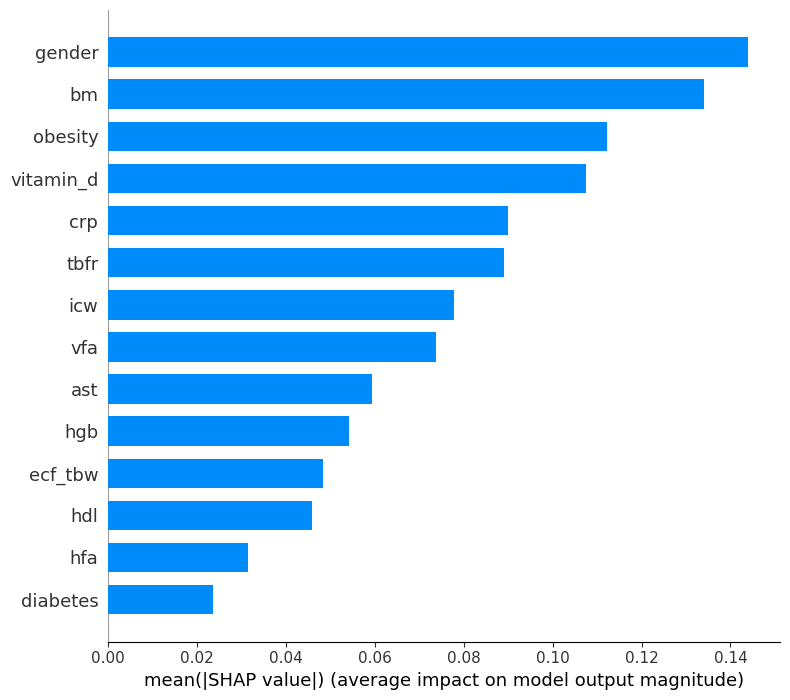

GridCV LASSO Model

2. Summary Plot (Beeswarm)...


c:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\Gallstone-prediction\scripts\shap_utils.py:77: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


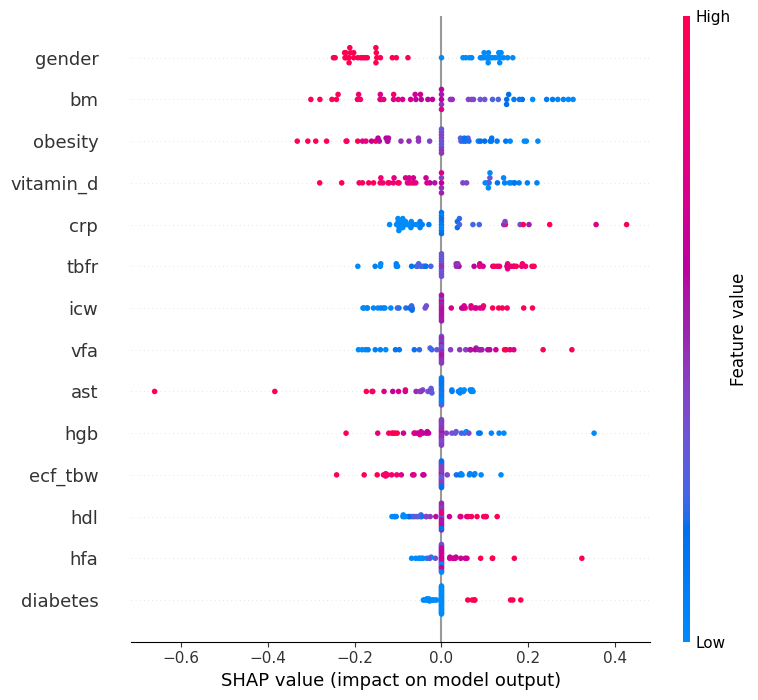

In [57]:
plot_shap_summary(shap_values = shap_values, X_test_sample=test_sample, title = "GridCV LASSO Model")

GridCV LASSO Model on data stratified by Gallstone + gender

1. Global Feature Importance (Bar Plot)...


c:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\Gallstone-prediction\scripts\shap_utils.py:67: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


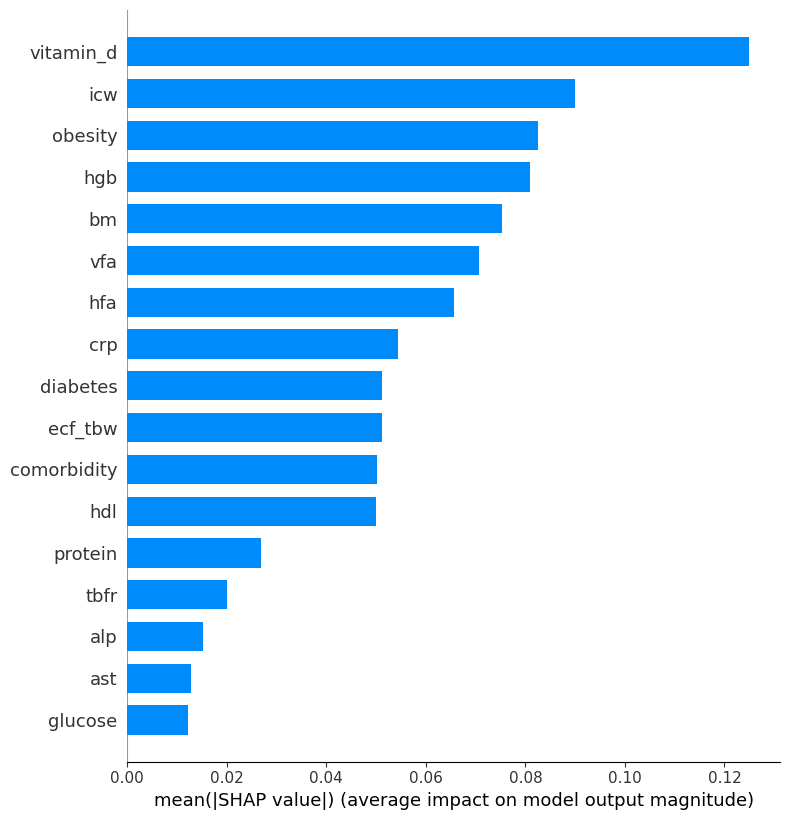

GridCV LASSO Model on data stratified by Gallstone + gender

2. Summary Plot (Beeswarm)...


c:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\Gallstone-prediction\scripts\shap_utils.py:77: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


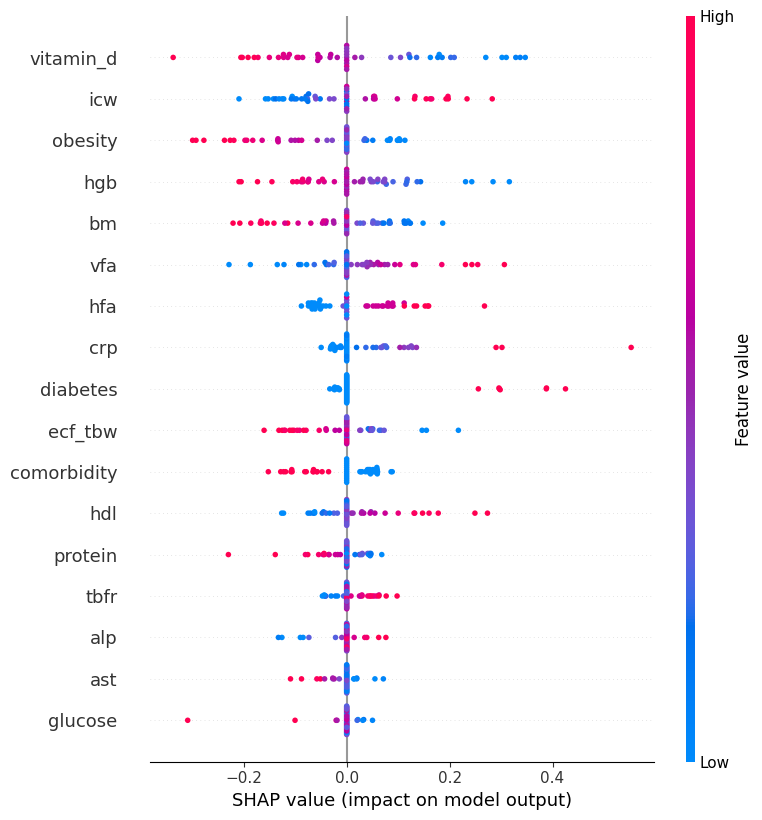

In [58]:
plot_shap_summary(shap_values = strat_shap_values, X_test_sample=test_sample_strat, title = "GridCV LASSO Model on data stratified by Gallstone + gender")


GridCV LASSO Model
Force Plot (Individual Explanation) for Sample Index 15...


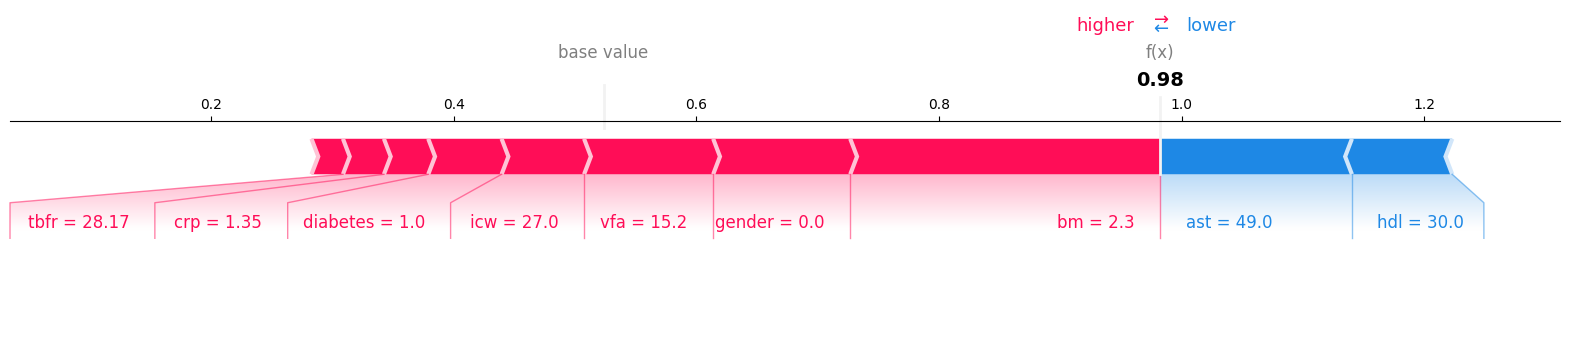

In [59]:
plot_shap_force(base_value = base_value, shap_values = shap_values, test_sample = test_sample, sample_index = 15,
                title = "GridCV LASSO Model")

GridCV LASSO Model on data stratified by Gallstone + gender
Force Plot (Individual Explanation) for Sample Index 15...


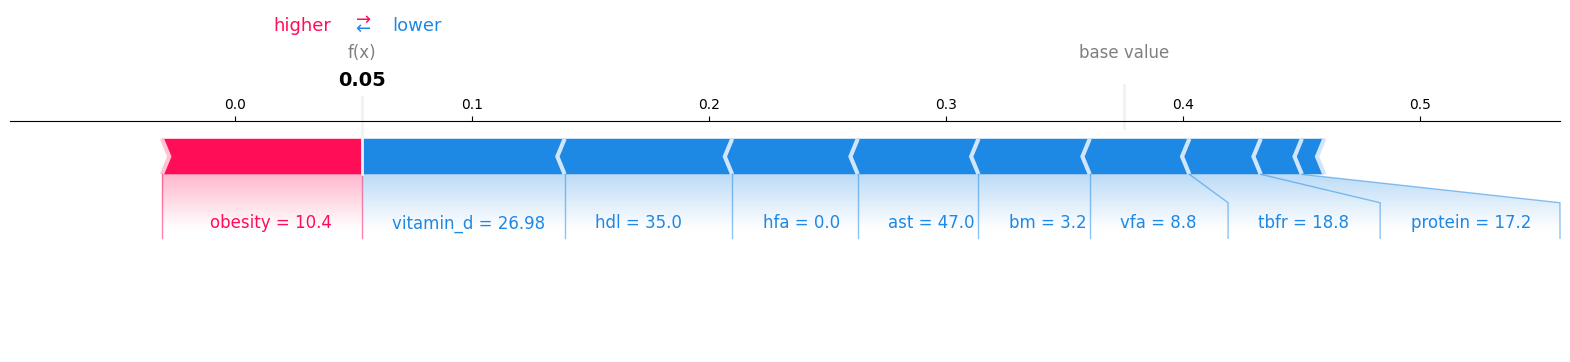

In [60]:
plot_shap_force(base_value = strat_base_value, shap_values = strat_shap_values, test_sample = test_sample_strat, sample_index = 15,
                 title = "GridCV LASSO Model on data stratified by Gallstone + gender")

#### 4.9. Final Takeaways

- Custom Validation Loop: Implementing a manual cross-validation loop was essential to correctly integrate the EarlyStopping callback and ensure unbiased monitoring of validation loss.

- Aggressive Regularization: The use of multi-layered regularization (Dropout and Elastic Net L1/L2) was required to control the high capacity of the neural network and successfully combat severe overfitting.

- Feature Simplification: Applying Lasso (L1) regularization for feature selection proved highly effective, simplifying the input space and providing an incremental performance boost in generalization.

- Transparency via SHAP: SHAP analysis was critical for establishing the required transparency, allowing us to explain individual predictions and confirm the complex NN model's viability for biomedical application.

**Key point: Full Workflow Demonstration**. The entire research process, from model definition to hyperparameter tuning via manual nested cross-validation and SHAP calculation, was demonstrated using fully contained and reusable Python scripts, ensuring the complete workflow is reproducible.